In [39]:
import numpy as np
import scipy.linalg as scl
import matplotlib.pyplot as plt

# Sparse Fourier approximation

### Discrete Fourier transform as a linear operator
Let's now consider two discretized signals $x_1, x_2$ that are periodic of period of period N: $x_i[n+N]=x_i[n]$.

The discrete fourier transform reads:
\begin{align*}
  X[k]= \sum_{n=0}^{N-1} x[n]e^{-2 \pi j \frac{kn}{N}}
\end{align*}
And the inverse discrete fourier transform reads:
\begin{align*}
  x[n]= \frac{1}{N} \sum_{k=0}^{N-1} X[k]e^{2 \pi j \frac{kn}{N}}
\end{align*}

it is very interesting to see that each element of the direct space is the result of a dot product with Fourier space basis, and conversely, each element of the Fourier space is also the result of a dot product with a vector of the analysis Fourier basis.
This is much more clear if we write the discrete Fourier transform as a matrix F:
$X = F^{-1} x$ and $x = F X$ where we have:

\begin{align}
    F = \frac{1}{N} \begin{pmatrix}
    1 & 1 & \cdots & 1\\
    1 & e^{2\pi j\frac{1}{N}} & \cdots & e^{2\pi j\frac{N-1}{N}}\\
    \vdots & \vdots & \vdots & \vdots \\
    1 & e^{2\pi j\frac{N-1}{N}} & \cdots & e^{2\pi j\frac{(N-1)(N-1)}{N}}\\
    \end{pmatrix}
\end{align}
where k indices are constant across a row, but are different along a column
and
 
\begin{align}
    F^{-1} = \begin{pmatrix}
    1 & 1 & \cdots & 1\\
    1 & e^{-2\pi j\frac{1}{N}} & \cdots & e^{-2\pi j\frac{N-1}{N}}\\
    \vdots & \vdots & \vdots & \vdots \\
    1 & e^{-2\pi j\frac{N-1}{N}} & \cdots & e^{-2\pi j\frac{(N-1)(N-1)}{N}}\\
    \end{pmatrix}
\end{align}
where n indices are constant across row, but are different along a column



In [51]:
# Simple numerical check of the definitions above
N = 4
F = np.zeros((N,N), dtype=np.complex64)
Fm = np.zeros_like(F)
ks = np.arange(N)
ns = np.arange(N)

# definition of F
for n in ns:
    F[n,:] = np.exp(2*np.pi*1j*ks*n/N)
F = F/N

# definition of F^(-1)
for k in ks:
    Fm[k,:] = np.exp(-2*np.pi*1j*k*ns/N)

# Small random test with vector, notice there is no FFTSHIFT here !
x=np.random.rand(N)+1j*np.random.rand(N)
r=np.dot(F,x)
assert np.allclose(r,np.fft.ifft(x)), 'F is not numerically close to ifft'
r=np.dot(Fm,x)
assert np.allclose(r,np.fft.fft(x)), 'Fm is not numerically close to fft'
# Check if they are inverse of each other
assert np.allclose(np.dot(F,Fm), np.identity(N, dtype=np.complex64), atol=1e-5), 'F and Fm are not numerically each other inv'
assert np.allclose(np.dot(Fm,F), np.identity(N, dtype=np.complex64), atol=1e-5), 'Fm and F are not numerically each other inv'

## Alternative definition of Fourier transform as a unitary matrix, and its property

It is interesting to notice that, depending on a scaling factor used for our definition, we can write that $G = \frac{1}{\sqrt{N}} F$ is a unitary matrix.
Ie the following equalities holds:
* $G.G^{\star} = Id(N)$
* $G^{\star}.G = Id(N)$

We recall that $G^{\star}$ is called the adjoint matrix of $G$, it is the transpose of G where each coefficient has been conjugated.
This construction is also sometimes called the Hermitian conjugate.
Showing that $\frac{1}{\sqrt{N}} F$ is the actual adjoint of $\sqrt{N} F^{-1}$ is rather easy if you notice that those matrices are both symmetric, and that $\overline{e^{\alpha j}} = e^{-\alpha j}$

We also recall that unitary matrices are also commuting matrices by construction: $AB = BA$ when one matrix commutes with its adjoint we also say that this matric is normal.
Interestingly, both $G^{\star}$ and $G$  have all their eigenvalues lying on the unit circle.
Thus, $G$ is diagonalizable; ie $G$ is unitarily similar to a diagonal matrix, as a consequence of the spectral theorem. Thus, G has a decomposition of the form
\begin{align}
    G = VDV^{\star}
\end{align}

where $V$ is also unitary, and D is diagonal and unitary.

In [98]:
# Lets define G and numerically check previous properties
F = np.zeros((N,N), dtype=np.complex64)
for n in ns:
    F[n,:] = np.exp(2*np.pi*1j*ks*n/N)
G = F/np.sqrt(N)

# definition of G^(-1)
Fm = np.zeros_like(F)
for k in ks:
    Fm[k,:] = np.exp(-2*np.pi*1j*k*ns/N)
Gm = Fm/np.sqrt(N)

def check_unitary_matrices(A, B):
    # Check if they are adjoint of each other.
    assert np.allclose(A.T.conj(), B), 'A adjoint is not numerically close to B'
    assert np.allclose(B.T.conj(), A), 'B adjoint is not numerically close to A'

    # Now check invert
    assert np.allclose(np.dot(A.T.conj(), A), np.identity(N, dtype=np.complex64), atol=1e-5), 'A adjoint is not numerically close to A inverse'
    assert np.allclose(np.dot(A, A.T.conj()), np.identity(N, dtype=np.complex64), atol=1e-5), 'A adjoint is not numerically close to A inverse'
    
check_unitary_matrices(G, Gm)

# This was not working IN GENERAL with original definition of F and Fm
assert not np.allclose(np.dot(F.T.conj(), F), np.identity(N, dtype=np.complex64), atol=1e-5), 'F adjoint is numerically close to Gm inverse in general !'
assert not np.allclose(np.dot(Fm.T.conj(), Fm), np.identity(N, dtype=np.complex64), atol=1e-5), 'Fm adjoint is not numerically close to F inverse in general !'

# Check for diagonalization with unitary matrices with SVD
u,s,vh = np.linalg.svd(G, full_matrices=False)
Ddiag = np.diag(s)
assert np.allclose(np.abs(Ddiag), np.identity(N, dtype=np.complex64), atol=1e-5), 'Ddiag has not all unit singular values'
assert np.allclose(np.dot(u, np.dot(Ddiag, vh)), G, atol=1e-5), 'SVD reconstruction is not ok'
check_unitary_matrices(u, u.T.conj())
check_unitary_matrices(vh.T.conj(), vh)
# Surprisingly here, SVD /= ED , u and vh are not adjoint of each other
assert not np.allclose(u.T.conj(), vh, atol=1e-5), 'SVD does return same as ED'

# Check for diagonalization with unitary matrices with ED
w,v = np.linalg.eig(G)
Ddiag = np.diag(w)
np.set_printoptions(precision=1)
print(np.dot(v, v.T.conj()))
assert np.allclose(np.abs(Ddiag), np.identity(N, dtype=np.complex64), atol=1e-5), 'Ddiag has not all unit singular values'
#check_unitary_matrices(v, v.T.conj())
assert np.allclose(np.dot(v, np.dot(Ddiag, v.T.conj())), G, atol=1e-5), 'QDQ-1 reconstruction is not ok'


#np.set_printoptions(precision=1)
#print(res)
#print(Vstar)
#assert np.allclose(np.dot(V, V), np.identity(N, dtype=np.complex64), atol=1e-5), 'V and Vstar are not unitary'
#assert np.allclose(np.dot(V, Vstar), np.identity(N, dtype=np.complex64), atol=1e-5), 'V and Vstar are not unitary'
#assert np.allclose(V.T.conj(), Vstar), 'V adjoint is not numerically close to Vstar'
#assert np.allclose(Vstar.T.conj(), V), 'Vstar adjoint is not numerically close to V'


[[ 1.+0.j  -0.-0.j   0.+0.1j -0.-0.j ]
 [-0.+0.j   1.+0.j   0.+0.j  -0.+0.j ]
 [ 0.-0.1j  0.-0.j   1.+0.j   0.-0.j ]
 [-0.+0.j  -0.+0.j   0.+0.j   1.+0.j ]]


AssertionError: QDQ-1 reconstruction is not ok

## Fourier matrices diagonalizes circulant matrices

Although this is not relevant to our current problem, we would like to recall this important property of the discrete Fourier transform, especially for "numerical" people use this powerful tool.

### Circular convolution as a linear operator
We also recall that discrete circular convolution reads:
\begin{align*}
  (s_1 \star s_2)[n] = \sum_{k=0}^{N-1} s_1[k] s_2[(n-k)\%N]
\end{align*}

It is interesting to notice that this convolution operator can be expressed as a linear operation, $(s_1 \star s_2) = S_2 s_1$ where we have:
\begin{align}
    S_2 = \begin{pmatrix}
    s_2[0] & s_2[N-1] & \cdots & s_2[1] \\
    s_2[1] & s_2[0] & \cdots & s_2[2] \\
    \vdots & \vdots & \vdots & \vdots \\
    s_2[N-1] & s_2[N-2] & \cdots & s_2[0] \\
    \end{pmatrix}
\end{align}
And one can easily see that this matrix is a circulant matrix

### Diagonalization of circulant matrices
From there, one can show that the $F, F^{-1}$ pair of matrices can be used to diagonalize any circulant matrices $C$. such that we can write $C = F D F^{-1}$ or, alternatively $D = F^{-1} C F$

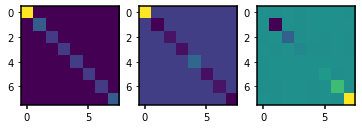

In [42]:
"""
  Check if fourier transform allows to diagonalize a circulant matrix
"""
N=8

#now generate the Fourier matrix
x = np.linspace(0, N-1, N) 
y = np.linspace(0, N-1, N)
xg, yg = np.meshgrid(x, y)
F=(1/N)*np.exp(2*np.pi*1j*xg*yg/N)
Fm=np.exp(-2*np.pi*1j*xg*yg/N)

#check that F and F_1 are inverse of each other
assert np.allclose(np.dot(F,Fm), np.identity(N)), 'Fm is not an inverse of F'

#Lets check in practice that Fourier matrix can be used to diagonalize circulant matrices
circulant=scl.circulant(np.random.randint(0,100,N))

#Now show the diagonalized version of the circulant matrix:
diag = np.dot(Fm,np.dot(circulant,F))

# Check reconstruction
assert np.allclose(circulant, np.dot(F, np.dot(diag,Fm))), 'Cannot reconstruct '
diag = np.dot(Fm,np.dot(circulant,F))

fig,ax = plt.subplots(1,3)
ax[0].imshow(np.absolute(diag))
ax[1].imshow(np.real(diag))
ax[2].imshow(np.imag(diag))

## Sparse approximation in Fourier domain

### Introduction:

In a quite famous paper, Bruckstein, Donoho and Elad have explored the link between the fundamental uncertainty principle (see our notebook on the Heisenberg–Pauli–Weyl inequality) and the resolution of systems of linear equations, the name of the paper was: From sparse solutions of systems of equations to sparse modeling of signals and images.

### stuff